In [33]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from mitdeeplearning import util
import random
from itertools import combinations
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Function for getting largest number of different groups in any of features

In [18]:
def get_max_nunieque(data):
    max_value=0
    for column in data.columns:
        #print(column+': ',end='')
        #print(data[column].nunique())
        if data[column].nunique() > max_value:
            max_value=data[column].nunique()
    return max_value

Function for transforming tabular data into image

In [20]:
def create_images(data):
    height=get_max_nunieque(data)+1
    width=len(data.columns)
    lista=[]
    for column in data.columns:
        dum=pd.get_dummies(data[column])
        lista.append(dum)
    images=[]
    for i in range(len(data)):
        image=np.zeros(shape=(height,width,1))
        for j in range(len(lista)):
            image[np.where(lista[j].iloc[i].values==1)[0][0],j]=255
        images.append(image)
    return np.asarray(images)

In [21]:
au_data=pd.read_csv('data/au_data_prepared.csv')

In [23]:
au_data

,A1,A4,A5,A6,A8,A9,A11,A12,A15,A2_bins,A3_bins,A7_bins,A10_bins,A13_bins,A14_bins
0,1,2,4,4,0,0,1,2,0,"(21.08, 22.5]","(11.0, 13.0]","(0.29, 2.0]","(-0.001, 1.0]","(27.2, 120.0]","(6.0, 100001.0]"
1,0,2,8,4,0,0,0,2,0,"(22.5, 23.25]","(6.75, 9.432]","(-0.001, 0.29]","(-0.001, 1.0]","(120.0, 186.8]","(0.999, 6.0]"
2,0,1,4,4,0,0,1,2,0,"(27.83, 29.649]","(1.5, 1.934]","(0.29, 2.0]","(-0.001, 1.0]","(186.8, 300.0]","(0.999, 6.0]"
3,0,1,5,3,1,1,1,2,1,"(21.08, 22.5]","(11.0, 13.0]","(-0.001, 0.29]","(7.0, 67.0]","(-0.001, 27.2]","(0.999, 6.0]"
4,1,2,6,4,1,1,0,2,1,"(19.67, 21.08]","(6.75, 9.432]","(0.29, 2.0]","(7.0, 67.0]","(27.2, 120.0]","(6.0, 100001.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,2,14,4,1,0,0,2,1,"(29.649, 31.57]","(9.432, 11.0]","(2.0, 28.5]","(-0.001, 1.0]","(-0.001, 27.2]","(0.999, 6.0]"
686,1,2,8,4,0,0,0,2,0,"(19.67, 21.08]","(0.247, 0.5]","(-0.001, 0.29]","(-0.001, 1.0]","(-0.001, 27.2]","(6.0, 100001.0]"
687,0,2,6,4,1,0,0,2,1,"(18.17, 19.67]","(9.432, 11.0]","(-0.001, 0.29]","(-0.001, 1.0]","(27.2, 120.0]","(0.999, 6.0]"
688,0,2,14,8,1,1,0,2,1,"(26.056, 27.83]","(13.0, 28.0]","(2.0, 28.5]","(-0.001, 1.0]","(27.2, 120.0]","(6.0, 100001.0]"


Feture/target split

In [24]:
au_data_y=au_data['A15'].to_numpy()
au_data_x=create_images(au_data.drop(columns=['A15']))

One of generated images

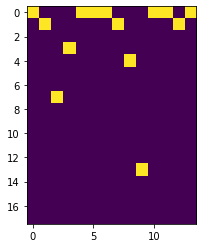

In [25]:
plt.imshow(np.squeeze(au_data_x[1]))

Function for  getting random batch of images

In [26]:
def get_batch(images,labels,batch_size):
    if(batch_size==483):
      return images,labels
    index=random.randrange(0,len(images)-batch_size,1)
    indexis=np.arange(index,index+batch_size,1)
    x=images[indexis,:,:]
    y=labels[indexis].astype('float32').reshape((-1,1))
    return x,y

Train/test split

In [27]:
x_train,x_test,y_train,y_test=train_test_split(au_data_x,au_data_y,test_size=0.30)

In [28]:
x_train.shape

(483, 18, 14, 1)

Creating model with specific degree of regularization (l1/l2)

In [29]:
def create_model(n_filters=12,l1_v=0,l2_v=0):
      model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=128,padding='same',activation='relu',strides=2,kernel_size=5,kernel_initializer=tf.keras.initializers.GlorotUniform(),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_v,l2=l2_v)),
        #tf.keras.layers.Dropout(0.25,seed=17),
        tf.keras.layers.Conv2D(filters=256,padding='same',activation='relu',strides=2,kernel_size=3,kernel_initializer=tf.keras.initializers.GlorotUniform(),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_v,l2=l2_v)),
        #tf.keras.layers.Dropout(0.25,seed=17),
        tf.keras.layers.Conv2D(filters=512,padding='same',activation='relu',strides=1,kernel_size=2,kernel_initializer=tf.keras.initializers.GlorotUniform(),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_v,l2=l2_v)),
        #tf.keras.layers.Dropout(0.25,seed=17),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16,activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=17),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_v,l2=l2_v)),
        #tf.keras.layers.Dropout(0.25,seed=17),
        tf.keras.layers.Dense(1,activation=None,kernel_initializer=tf.keras.initializers.GlorotUniform(seed=17),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_v,l2=l2_v))])
      return model

In [44]:
au_model=create_model(l2_v=0.4)

Training with diagram of model  accuracy 

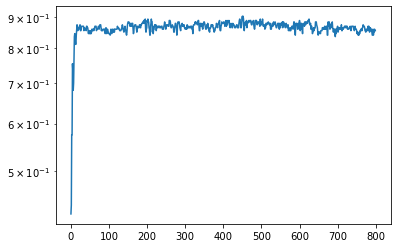

100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Standard CNN accuracy on test set: 0.8551
Standard CNN accuracy on training set: 0.9565
Best accuracy result: 0.9034


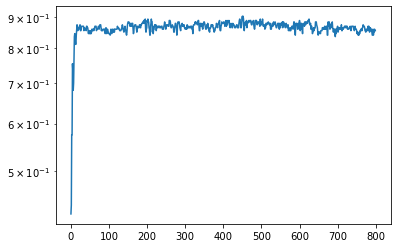

In [45]:

batch_size=115
num_epochs=200
learning_rate=5e-4
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4)
loss_history = util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = util.PeriodicPlotter(sec=0.2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x,y):
    with tf.GradientTape() as tape:
        logits=au_model(x)
        #print(logits.shape)
      
        #print(y.shape)
        loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=logits)
        regularization_loss=tf.reduce_mean(au_model.losses)
        loss=loss+regularization_loss
    grads=tape.gradient(loss,au_model.trainable_variables)
    optimizer.apply_gradients(zip(grads,au_model.trainable_variables))
    return loss
accuracy_history=[]
for epoch in range(num_epochs):
    for idx in tqdm(range(x_train.shape[0]//batch_size)):
        x,y=get_batch(x_train,y_train,batch_size)
        loss=standard_train_step(x,y)
      
          
        y_predicted=tf.round(tf.nn.sigmoid(au_model.predict(x_test)))
        y_test=y_test.astype('float32').reshape(-1,1)
        acc_standard=tf.reduce_mean(tf.cast(tf.equal(y_test,y_predicted),tf.float32))
        accuracy_history.append(acc_standard)
        #loss_history.append(loss.numpy().mean())
        plotter.plot(accuracy_history)

y_predicted=tf.round(tf.nn.sigmoid(au_model.predict(x_test)))
y_test=y_test.astype('float32').reshape(-1,1)
acc_standard=tf.reduce_mean(tf.cast(tf.equal(y_test,y_predicted),tf.float32))
print("Standard CNN accuracy on test set: {:.4f}".format(acc_standard.numpy()))

y_predicted=tf.round(tf.nn.sigmoid(au_model.predict(x_train)))
y_train=y_train.astype('float32').reshape(-1,1)
acc_standard=tf.reduce_mean(tf.cast(tf.equal(y_train,y_predicted),tf.float32))
print("Standard CNN accuracy on training set: {:.4f}".format(acc_standard.numpy()))

print("Best accuracy result: {:.4f}".format(max(accuracy_history)))

In [46]:
print("Best accuracy result: {:.4f}".format(max(accuracy_history)))

Best accuracy result: 0.9034


Confusion matrix and results

In [47]:
y_predicted=tf.round(tf.nn.sigmoid(au_model.predict(x_test)))
y_test=y_test.astype('float32').reshape(-1,1)
cm=confusion_matrix(y_test,y_predicted)
report=classification_report(y_test,y_predicted)
print(cm)
print(report)

[[109  10]
 [ 20  68]]
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       119
         1.0       0.87      0.77      0.82        88

    accuracy                           0.86       207
   macro avg       0.86      0.84      0.85       207
weighted avg       0.86      0.86      0.85       207

